# Approximate a Function using Neural Networks

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import torch.nn as nn
import torch

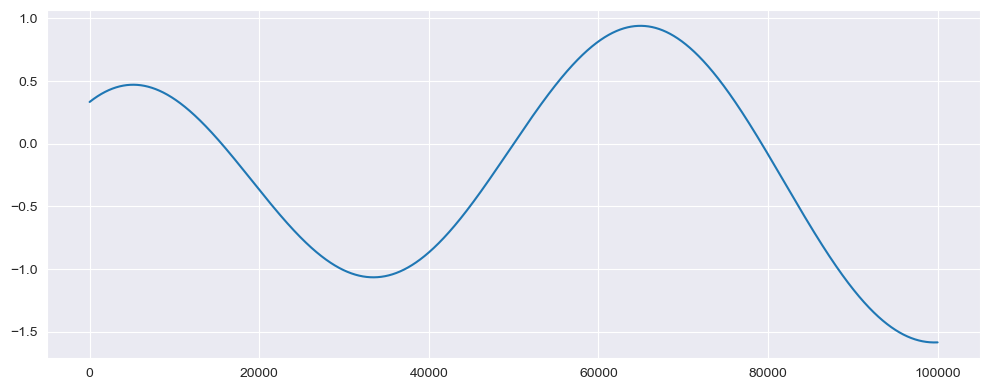

In [35]:
# Define a function we want to approximate

f_x = lambda x: np.sin(x) - (x**2 / 40)

X = np.arange(-5, 5, .0001) # -5.0, -4.9, -4.8, ..., 0, ..., 4.8, 4.9, 5.0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(f_x(X))
plt.tight_layout()
plt.show()

In [36]:
X.size

100000

In [4]:
# Define the Pytorch Models (nn.Module)

class SigmoidNeuralNet(nn.Module):
    """Double-layer neural network with sigmoid activation."""

    def __init__(self, num_features, nodes=4):
        super().__init__()
        self.layer1  = nn.Linear(in_features=num_features, out_features=nodes)
        self.layer2  = nn.Linear(in_features=nodes, out_features=num_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        logits1 = self.layer1(inputs)
        activations = self.sigmoid(logits1)
        output = self.layer2(activations)
        return output

class ReluNeuralNet(nn.Module):
    """Double-layer neural network with Relu activation."""

    def __init__(self, num_features, nodes=4):
        super().__init__()
        self.layer1  = nn.Linear(in_features=num_features, out_features=nodes)
        self.layer2  = nn.Linear(in_features=nodes, out_features=num_features)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        logits1 = self.layer1(inputs)
        activations = self.relu(logits1)
        output = self.layer2(activations)
        return output

In [5]:
# Define the Dataset and DataLoader

class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.x = inputs
        self.y = targets

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

In [47]:
# Dataset
inputs = torch.randint(-10, 10, (2000, 1)).float()
targets = f_x(inputs)
dataset = CustomDataset(inputs, targets)
dataloader =  DataLoader(dataset, batch_size=32, drop_last=False, shuffle=False)

# Model(s)
num_features = inputs.size(-1)
model = SigmoidNeuralNet(num_features, nodes=4)
#model = ReluNeuralNet(num_features, nodes=4)

# Loss Function
loss = nn.MSELoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)


C:\Users\Filippo Corti\AppData\Local\Temp\ipykernel_3244\3771121597.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f_x = lambda x: np.sin(x) - (x**2 / 40)


In [48]:
# TRAINING

device = "cpu"

epochs = 500

mean_error = list()
predictions = list()

model = model.to(device)

for epoch in range(epochs): # Progress Bar
    errors = list()
    for batch in dataloader:
        # 0. Get data and target
        features, target = batch
        features = features.to(device)
        target = target.to(device)
        # 1. Predict using the model
        y_pred = model(features)
        # 2. Compute error
        error = loss(y_pred, target)
        # 3. Back-propagate the loss (sets values for gradients)
        error.backward()
        # 4. Update model (using gradients)
        optimizer.step()
        # 5. Clear gradients
        model.zero_grad()
        # 6. Report stats
        errors.append(error.item())
    with torch.no_grad():
        mean_error.append(np.mean(errors))
        X_tensor = torch.tensor(X.reshape(-1, 1), dtype=torch.float32).to(device)
        preds = model(X_tensor).cpu().numpy().ravel()  # move back to CPU for plotting
    predictions.append(preds)

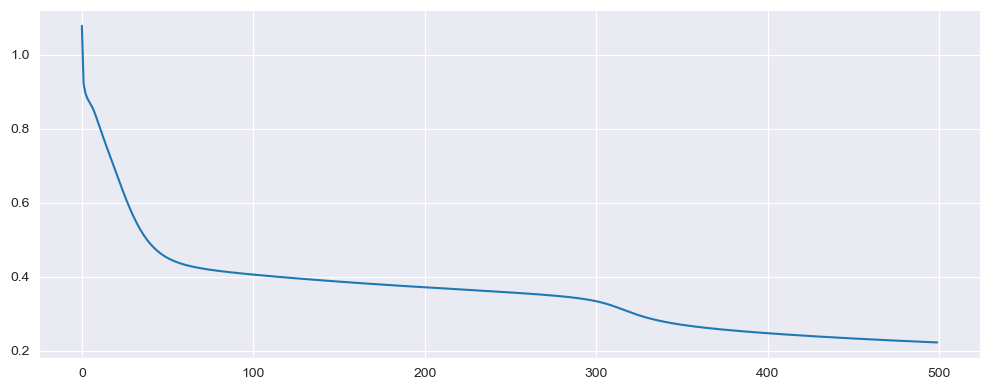

In [49]:
# Plot the Learning Process

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(mean_error)
plt.tight_layout()
plt.show()

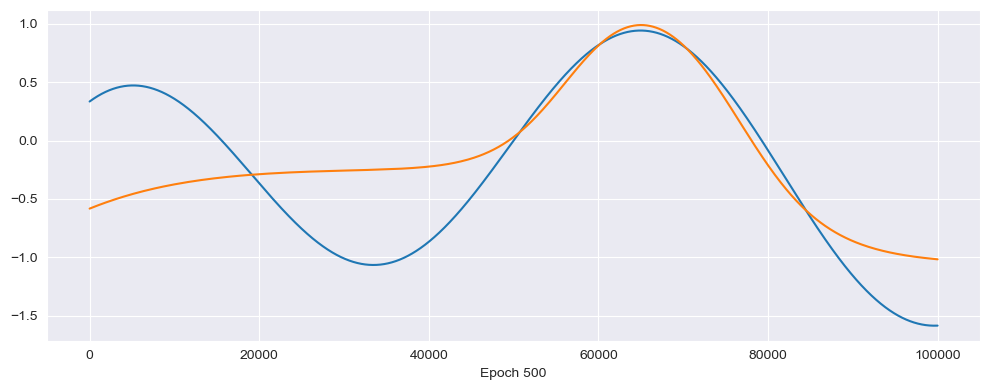

In [50]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(f_x(X))
ax.plot(predictions[-1])
ax.set_xlabel('Epoch {}'.format(500))
plt.tight_layout()
plt.show()